In [4]:
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau




/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [5]:

# Set the path to your dataset
dataset_path = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset' 


In [6]:
# Define the categories (classes)
categories = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

In [7]:
# Define the image size for resizing
image_size = (150, 150)


In [8]:
# Load and preprocess the dataset
def load_dataset():
    data = []
    labels = []
    for category in categories:
        image_path = os.path.join(dataset_path, category, 'images')
        label = categories.index(category)
        for image_name in os.listdir(image_path):
            image_file = os.path.join(image_path, image_name)
            image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, image_size)
            data.append(image)
            labels.append(label)
    data = np.array(data, dtype='float32')
    labels = np.array(labels)
    return data, labels



In [9]:
# Load the dataset
data, labels = load_dataset()

In [10]:
# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)


In [11]:

# Normalize the image data
x_train = x_train / 255.0
x_test = x_test / 255.0


In [12]:
# Create an image data generator with augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)


In [13]:
# Reshape the x_train array to include the channel dimension
x_train = np.reshape(x_train, (*x_train.shape, 1))

# Fit the data generator on the training set
datagen.fit(x_train)

In [14]:
# Build the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=x_train.shape[1:]))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(categories), activation='softmax'))



In [15]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
# Define the learning rate reduction callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

In [17]:
# Train the model with augmented data and learning rate reduction callback
history = model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=20, validation_data=(x_test, y_test), callbacks=[reduce_lr])

Epoch 1/20
530/530 [==============================] - 51s 74ms/step - loss: 0.9901 - accuracy: 0.5843 - val_loss: 0.7516 - val_accuracy: 0.6860 - lr: 0.0010
Epoch 2/20
530/530 [==============================] - 38s 72ms/step - loss: 0.8167 - accuracy: 0.6727 - val_loss: 0.6770 - val_accuracy: 0.6964 - lr: 0.0010
Epoch 3/20
530/530 [==============================] - 37s 70ms/step - loss: 0.7385 - accuracy: 0.7046 - val_loss: 0.6107 - val_accuracy: 0.7472 - lr: 0.0010
Epoch 4/20
530/530 [==============================] - 37s 70ms/step - loss: 0.6996 - accuracy: 0.7238 - val_loss: 0.5559 - val_accuracy: 0.7782 - lr: 0.0010
Epoch 5/20
530/530 [==============================] - 37s 71ms/step - loss: 0.6555 - accuracy: 0.7421 - val_loss: 0.5305 - val_accuracy: 0.7836 - lr: 0.0010
Epoch 6/20
530/530 [==============================] - 37s 69ms/step - loss: 0.6174 - accuracy: 0.7628 - val_loss: 0.5026 - val_accuracy: 0.7926 - lr: 0.0010
Epoch 7/20
530/530 [==============================] - 37s 

In [18]:
# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

133/133 [==============================] - 1s 8ms/step - loss: 0.2808 - accuracy: 0.8932
Test loss: 0.2808355987071991
Test accuracy: 0.8932199478149414


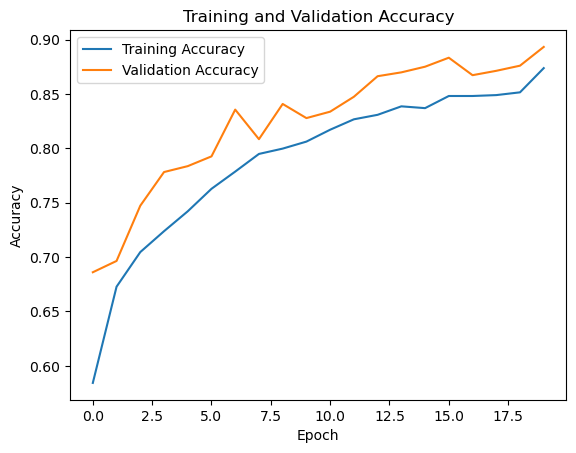

In [19]:
# Plot training and validation accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

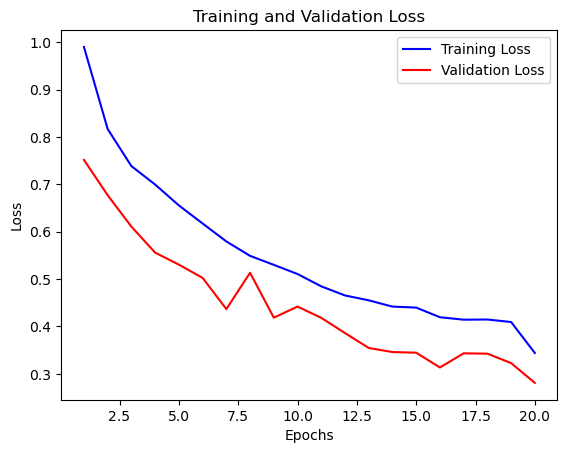

In [20]:
# Plot training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




In [22]:
# Load and preprocess a single test image
test_image_path = '/kaggle/input/testpng/c2.png'  # Replace with the path to your test image
test_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
test_image = cv2.resize(test_image, image_size)
test_image = np.array(test_image, dtype='float32') / 255.0
test_image = np.reshape(test_image, (*test_image.shape, 1))

prediction = model.predict(np.array([test_image]))
predicted_class_index = np.argmax(prediction)
predicted_class = categories[predicted_class_index]
print(f'Predicted class: {predicted_class}')

1/1 [==============================] - 0s 23ms/step
Predicted class: COVID
